In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.applications import ResNet50V2
import optuna
from tensorflow.keras.optimizers import Adam

In [2]:
df=pd.read_csv("train.csv")
df

,Image_name,Emotion
0,63119.png,happy
1,61769.png,neutral
2,95472.png,disgust
3,93515.png,neutral
4,56585.png,angry
...,...,...
7097,33657.png,angry
7098,91316.png,disgust
7099,86170.png,surprise
7100,8959.png,fear


In [3]:
df["Emotion"].value_counts()
##8 unique emotions

Emotion
happy        1008
neutral       899
disregard     881
fear          871
surprise      871
sorrow        871
angry         851
disgust       850
Name: count, dtype: int64

In [ ]:
import os
import shutil
from PIL import Image, UnidentifiedImageError

image_dir = "Images"
output_dir = "Sorted_"
os.makedirs(output_dir, exist_ok=True)

target_size = (224, 224)  # (Width, Height) for PIL

for _, row in df.iterrows():
    image_name = row["Image_name"]
    emotion = str(row["Emotion"])

    emotion_folder = os.path.join(output_dir, emotion)
    os.makedirs(emotion_folder, exist_ok=True)

    src_path = os.path.join(image_dir, image_name)
    dst_path = os.path.join(emotion_folder, image_name)

    if os.path.exists(src_path):
        try:
            with Image.open(src_path) as img:
                img = img.resize(target_size)  # Resize to (224, 224)
                img = img.convert("RGB")
                img.save(dst_path)

            os.remove(src_path)

        except UnidentifiedImageError:
            print(f"Skipping corrupted image: {src_path}")
        except Exception as e:
            print(f"Error processing {src_path}: {e}")
    else:
        print(f"Warning: {src_path} not found!")

print("Sorting and resizing complete!")

In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found!")

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    validation_split=0.2)  # 20% for validation

In [8]:
training_set = train_datagen.flow_from_directory(r'Sorted',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    shuffle=True)

validation_set = train_datagen.flow_from_directory(r'Sorted',
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        class_mode='categorical',
                                                        subset='validation',
                                                        shuffle=True)

Found 5683 images belonging to 8 classes.
Found 1418 images belonging to 8 classes.


In [9]:
tf.keras.backend.clear_session()

In [10]:
from tensorflow.keras.applications import VGG16

In [11]:
from tensorflow.keras.applications import VGG16

def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    dense_units = trial.suggest_int('dense_units', 128, 512, step=128)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)

    vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

    for layer in vgg.layers:
        layer.trainable = False

    x = Flatten()(vgg.output)
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    prediction = Dense(8, activation='softmax')(x)

    model = Model(inputs=vgg.input, outputs=prediction)

    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    hist = model.fit(
        training_set,
        validation_data=validation_set,
        epochs=10,
        steps_per_epoch=len(training_set),
        validation_steps=len(validation_set),
        verbose=1
    )

    val_acc = max(hist.history['val_accuracy'])
    return val_acc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

best_params = study.best_params
print("Best Parameters:", best_params)

[I 2025-03-28 12:01:58,883] A new study created in memory with name: no-name-6c5ed46a-a081-4a6a-8a60-736841c0dece
C:\Users\abinj\AppData\Local\Temp\ipykernel_4216\879827615.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\abinj\AppData\Local\Temp\ipykernel_4216\879827615.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)


Epoch 1/10
178/178 [==============================] - 150s 703ms/step - loss: 1.9324 - accuracy: 0.2539 - val_loss: 1.7302 - val_accuracy: 0.3575
Epoch 2/10
178/178 [==============================] - 62s 346ms/step - loss: 1.7167 - accuracy: 0.3451 - val_loss: 1.6290 - val_accuracy: 0.4020
Epoch 3/10
178/178 [==============================] - 57s 317ms/step - loss: 1.6314 - accuracy: 0.3794 - val_loss: 1.5686 - val_accuracy: 0.4323
Epoch 4/10
178/178 [==============================] - 58s 325ms/step - loss: 1.5621 - accuracy: 0.4109 - val_loss: 1.5036 - val_accuracy: 0.4732
Epoch 5/10
178/178 [==============================] - 59s 329ms/step - loss: 1.5078 - accuracy: 0.4397 - val_loss: 1.4962 - val_accuracy: 0.4549
Epoch 6/10
178/178 [==============================] - 60s 334ms/step - loss: 1.4670 - accuracy: 0.4496 - val_loss: 1.4759 - val_accuracy: 0.4669
Epoch 7/10
178/178 [==============================] - 58s 325ms/step - loss: 1.4290 - accuracy: 0.4739 - val_loss: 1.4405 - val_a

[I 2025-03-28 12:13:24,427] Trial 0 finished with value: 0.49929478764533997 and parameters: {'learning_rate': 3.5114657866247246e-05, 'dense_units': 256, 'dropout_rate': 0.4733306647930199}. Best is trial 0 with value: 0.49929478764533997.


Epoch 1/10
178/178 [==============================] - 58s 320ms/step - loss: 1.8594 - accuracy: 0.2882 - val_loss: 1.6501 - val_accuracy: 0.3787
Epoch 2/10
178/178 [==============================] - 57s 319ms/step - loss: 1.6296 - accuracy: 0.3741 - val_loss: 1.5373 - val_accuracy: 0.4401
Epoch 3/10
178/178 [==============================] - 58s 323ms/step - loss: 1.5276 - accuracy: 0.4154 - val_loss: 1.5390 - val_accuracy: 0.4464
Epoch 4/10
178/178 [==============================] - 58s 327ms/step - loss: 1.4736 - accuracy: 0.4411 - val_loss: 1.4540 - val_accuracy: 0.4760
Epoch 5/10
178/178 [==============================] - 58s 328ms/step - loss: 1.4139 - accuracy: 0.4742 - val_loss: 1.4438 - val_accuracy: 0.4810
Epoch 6/10
178/178 [==============================] - 59s 333ms/step - loss: 1.3673 - accuracy: 0.4941 - val_loss: 1.3870 - val_accuracy: 0.4845
Epoch 7/10
178/178 [==============================] - 59s 332ms/step - loss: 1.3412 - accuracy: 0.5092 - val_loss: 1.3912 - val_ac

[I 2025-03-28 12:23:45,412] Trial 1 finished with value: 0.5162200331687927 and parameters: {'learning_rate': 6.576991592121238e-05, 'dense_units': 512, 'dropout_rate': 0.41547437316832425}. Best is trial 1 with value: 0.5162200331687927.


Epoch 1/10
178/178 [==============================] - 61s 328ms/step - loss: 1.8244 - accuracy: 0.3102 - val_loss: 1.6185 - val_accuracy: 0.3900
Epoch 2/10
178/178 [==============================] - 58s 323ms/step - loss: 1.6094 - accuracy: 0.3935 - val_loss: 1.5329 - val_accuracy: 0.4365
Epoch 3/10
178/178 [==============================] - 59s 330ms/step - loss: 1.5216 - accuracy: 0.4366 - val_loss: 1.4846 - val_accuracy: 0.4647
Epoch 4/10
178/178 [==============================] - 59s 329ms/step - loss: 1.4452 - accuracy: 0.4612 - val_loss: 1.4623 - val_accuracy: 0.4443
Epoch 5/10
178/178 [==============================] - 59s 329ms/step - loss: 1.3957 - accuracy: 0.4851 - val_loss: 1.4345 - val_accuracy: 0.4788
Epoch 6/10
178/178 [==============================] - 60s 336ms/step - loss: 1.3657 - accuracy: 0.4982 - val_loss: 1.4122 - val_accuracy: 0.4986
Epoch 7/10
178/178 [==============================] - 60s 336ms/step - loss: 1.3221 - accuracy: 0.5152 - val_loss: 1.3905 - val_ac

[I 2025-03-28 12:33:54,498] Trial 2 finished with value: 0.5352609157562256 and parameters: {'learning_rate': 7.947061735954904e-05, 'dense_units': 384, 'dropout_rate': 0.3802388622966024}. Best is trial 2 with value: 0.5352609157562256.


Epoch 1/10
178/178 [==============================] - 58s 322ms/step - loss: 2.0987 - accuracy: 0.2404 - val_loss: 1.7533 - val_accuracy: 0.3244
Epoch 2/10
178/178 [==============================] - 57s 322ms/step - loss: 1.7823 - accuracy: 0.3025 - val_loss: 1.6728 - val_accuracy: 0.3808
Epoch 3/10
178/178 [==============================] - 57s 321ms/step - loss: 1.7345 - accuracy: 0.3148 - val_loss: 1.6313 - val_accuracy: 0.3977
Epoch 4/10
178/178 [==============================] - 58s 323ms/step - loss: 1.6966 - accuracy: 0.3301 - val_loss: 1.5538 - val_accuracy: 0.4126
Epoch 5/10
178/178 [==============================] - 58s 323ms/step - loss: 1.6569 - accuracy: 0.3352 - val_loss: 1.5517 - val_accuracy: 0.4175
Epoch 6/10
178/178 [==============================] - 57s 321ms/step - loss: 1.6506 - accuracy: 0.3496 - val_loss: 1.5416 - val_accuracy: 0.4111
Epoch 7/10
178/178 [==============================] - 57s 322ms/step - loss: 1.6196 - accuracy: 0.3510 - val_loss: 1.5142 - val_ac

[I 2025-03-28 12:43:30,539] Trial 3 finished with value: 0.44710859656333923 and parameters: {'learning_rate': 0.0008784692266550899, 'dense_units': 256, 'dropout_rate': 0.3675758520643393}. Best is trial 2 with value: 0.5352609157562256.


Epoch 1/10
178/178 [==============================] - 58s 322ms/step - loss: 2.0712 - accuracy: 0.2903 - val_loss: 1.6114 - val_accuracy: 0.4154
Epoch 2/10
178/178 [==============================] - 57s 319ms/step - loss: 1.6616 - accuracy: 0.3546 - val_loss: 1.5240 - val_accuracy: 0.4401
Epoch 3/10
178/178 [==============================] - 57s 322ms/step - loss: 1.5818 - accuracy: 0.3942 - val_loss: 1.5246 - val_accuracy: 0.4394
Epoch 4/10
178/178 [==============================] - 57s 321ms/step - loss: 1.5721 - accuracy: 0.3984 - val_loss: 1.4855 - val_accuracy: 0.4598
Epoch 5/10
178/178 [==============================] - 57s 319ms/step - loss: 1.5077 - accuracy: 0.4239 - val_loss: 1.4794 - val_accuracy: 0.4323
Epoch 6/10
178/178 [==============================] - 58s 327ms/step - loss: 1.4747 - accuracy: 0.4330 - val_loss: 1.4301 - val_accuracy: 0.4781
Epoch 7/10
178/178 [==============================] - 57s 319ms/step - loss: 1.4701 - accuracy: 0.4364 - val_loss: 1.4321 - val_ac

[I 2025-03-28 12:53:04,797] Trial 4 finished with value: 0.5155147910118103 and parameters: {'learning_rate': 0.0006982843233863231, 'dense_units': 512, 'dropout_rate': 0.3558425581412046}. Best is trial 2 with value: 0.5352609157562256.


Best Parameters: {'learning_rate': 7.947061735954904e-05, 'dense_units': 384, 'dropout_rate': 0.3802388622966024}


In [20]:
# best_params ={'learning_rate': 0.0001796570547939637, 'dense_units': 256, 'dropout_rate': 0.35815389602701575}
# Best Params={'learning_rate': 7.947061735954904e-05, 'dense_units': 384, 'dropout_rate': 0.3802388622966024}
best_params={'learning_rate': 7.947061735954904e-05, 'dense_units': 256, 'dropout_rate': 0.3802388622966024}

In [21]:
vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
x = Dense(best_params['dense_units'], activation='relu')(x)
x = Dropout(best_params['dropout_rate'])(x)
prediction = Dense(8, activation='softmax')(x)

model_vgg = Model(inputs=vgg.input, outputs=prediction)

optimizer = Adam(learning_rate=best_params['learning_rate'])

model_vgg.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

hist = model_vgg.fit(
    training_set,
    validation_data=validation_set,
    epochs=20,
    steps_per_epoch=len(training_set),
    validation_steps=len(validation_set)
)

Epoch 1/20
178/178 [==============================] - 174s 963ms/step - loss: 1.8449 - accuracy: 0.2965 - val_loss: 1.6497 - val_accuracy: 0.3956
Epoch 2/20
178/178 [==============================] - 57s 322ms/step - loss: 1.6252 - accuracy: 0.3862 - val_loss: 1.5413 - val_accuracy: 0.4443
Epoch 3/20
178/178 [==============================] - 60s 335ms/step - loss: 1.5277 - accuracy: 0.4250 - val_loss: 1.4723 - val_accuracy: 0.4683
Epoch 4/20
178/178 [==============================] - 62s 342ms/step - loss: 1.4680 - accuracy: 0.4568 - val_loss: 1.4862 - val_accuracy: 0.4506
Epoch 5/20
178/178 [==============================] - 60s 338ms/step - loss: 1.4328 - accuracy: 0.4705 - val_loss: 1.4221 - val_accuracy: 0.4944
Epoch 6/20
178/178 [==============================] - 61s 342ms/step - loss: 1.3927 - accuracy: 0.4857 - val_loss: 1.3897 - val_accuracy: 0.5035
Epoch 7/20
178/178 [==============================] - 60s 334ms/step - loss: 1.3560 - accuracy: 0.4985 - val_loss: 1.3767 - val_a

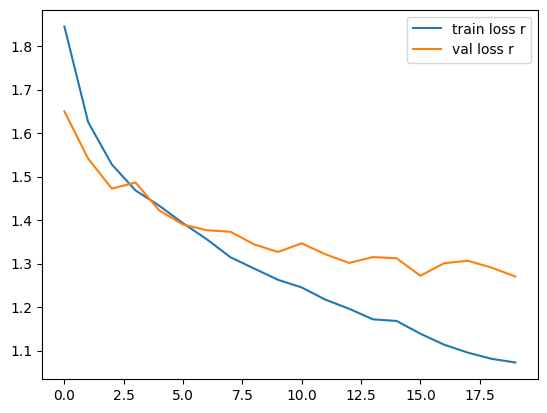

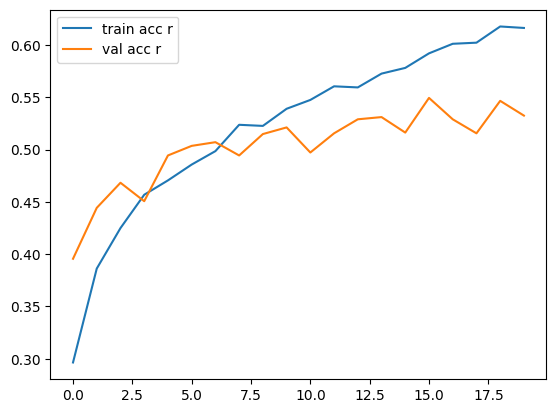

In [22]:
# loss
plt.plot(hist.history['loss'], label='train loss r')
plt.plot(hist.history['val_loss'], label='val loss r')
plt.legend()
plt.show()

# accuracies
plt.plot(hist.history['accuracy'], label='train acc r')
plt.plot(hist.history['val_accuracy'], label='val acc r')
plt.legend()
plt.show()

In [23]:
model_vgg.save(r'facefeatures_model_vgg16.h5')

In [24]:
sorted(['happy', 'neutral', 'disgust', 'angry', 'fear', 'disregard','surprise', 'sorrow'])

['angry',
 'disgust',
 'disregard',
 'fear',
 'happy',
 'neutral',
 'sorrow',
 'surprise']

In [25]:
from tensorflow.keras.preprocessing import image
import os

model = tf.keras.models.load_model("facefeatures_model_vgg16.h5")

image_dir = "Images"

tf_df = pd.read_csv("test.csv")

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) 
    img_array = np.expand_dims(img_array, axis=0) 
    img_array /= 255.0  
    return img_array

predictions = []

label=['angry',
 'disgust',
 'disregard',
 'fear',
 'happy',
 'neutral',
 'sorrow',
 'surprise']

for _, row in tf_df.iterrows():
    image_name = row["Image_name"]
    src_path = os.path.join(image_dir, image_name)

    if not os.path.exists(src_path):
        print(f"Warning: {src_path} not found.")
        continue

    img_array = preprocess_image(src_path)

    pred = model.predict(img_array)
    predicted_class = np.argmax(pred)

    predictions.append(label[predicted_class])

output_df = pd.DataFrame(predictions, columns=["Emotion"])
output_df.to_csv("predictions_vgg.csv", index=False)

1/1 [==============================] - 0s 31ms/step
